In [14]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.svm import SVC
from imblearn.combine import SMOTETomek
from collections import Counter
import joblib
import matplotlib.pyplot as plt
from utils.elpv_reader import load_dataset
from sklearn.metrics import confusion_matrix
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=metrics._classification.UndefinedMetricWarning)

In [2]:
def proportion_compute(label_set):
    label1, label2, label3, label4 = 0, 0, 0, 0
    for i in range(len(label_set)):
        if label_set[i] == 0:
            label1 += 1
        elif label_set[i] == 1:
            label2 += 1
        elif label_set[i] == 2:
            label3 += 1
        else:
            label4 += 1
    print("The percentage of the label 0 in the train set is: {:.2%}".format(label1 / len(label_set)))
    print("The percentage of the label 1 in the train set is: {:.2%}".format(label2 / len(label_set)))
    print("The percentage of the label 2 in the train set is: {:.2%}".format(label3 / len(label_set)))
    print("The percentage of the label 3 in the train set is: {:.2%}".format(label4 / len(label_set)))

### Step1:  Load the dataset

In [3]:
# Respectively: image, reflection probability, type. Our classifier needs to classify based on reflection probability
images, proba, types = load_dataset()
print(f"The size of the data set is: {images.shape[0]}")
print(f"The size of the image is: {images.shape[1]} * {images.shape[2]}")
print(proba)
print(types)

The size of the data set is: 2624
The size of the image is: 300 * 300
[1. 1. 1. ... 0. 0. 0.]
['mono' 'mono' 'mono' ... 'poly' 'poly' 'poly']


In [4]:
# change label, label will be 0 1 2 3
label_mapping = {0.0: 0, 0.3333333333333333: 1, 0.6666666666666666: 2, 1.0: 3}
for x in range(len(proba)):
    if proba[x] in label_mapping:
        proba[x] = label_mapping[proba[x]]
print(proba)

[3. 3. 3. ... 0. 0. 0.]


### Step2: Feature extraction

(2624, 256)


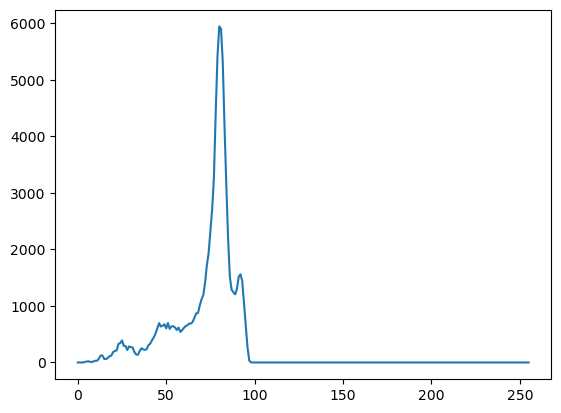

In [5]:
# Convert each image to the pixel histogram
image_his = []
for image in images:
    hist = cv2.calcHist([image], [0], None, [256], [0.0, 256.0])
    image_his.append(hist.flatten())
    
image_his = np.array(image_his)
print(image_his.shape)
plt.plot(image_his[0])
plt.show()

### Step3: Split the dataset into train set and test set

In [23]:
x_train, x_test, y_train, y_test = train_test_split(image_his, proba, test_size=0.25, stratify=proba, random_state=42)
# statistics of the proportion of each label in the training set
print("Original train set shape %s" %Counter(y_train))
proportion_compute(y_train)

# normalization
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)

Original train set shape Counter({0.0: 1131, 3.0: 536, 1.0: 221, 2.0: 80})
The percentage of the label 0 in the train set is: 57.47%
The percentage of the label 1 in the train set is: 11.23%
The percentage of the label 2 in the train set is: 4.07%
The percentage of the label 3 in the train set is: 27.24%


### Step4: Data augmentation

In [24]:
# due to the imbalance of the proportion of each type of samples in the training set, all samples were comprehensively sampled.
smt = SMOTETomek(random_state=42)
new_x_train, new_y_train = smt.fit_resample(x_train, y_train)
print("After sampling, the train set shape %s" %Counter(new_y_train))
proportion_compute(new_y_train)

After sampling, the train set shape Counter({2.0: 1126, 1.0: 1120, 3.0: 1108, 0.0: 1098})
The percentage of the label 0 in the train set is: 24.66%
The percentage of the label 1 in the train set is: 25.16%
The percentage of the label 2 in the train set is: 25.29%
The percentage of the label 3 in the train set is: 24.89%


### Step5: Use the PCA and SVM classifier to process all dataset

In [11]:
pipeline = Pipeline([
    ('pca', PCA()),
    ('svm', SVC())
])

param_grid = [{
    'pca__n_components': np.linspace(1, image_his.shape[1], 50, dtype='int'),
    'svm__C': [0.1, 1, 10, 20, 50, 100],
    'svm__kernel': ['linear']
},
{
    'pca__n_components': np.linspace(1, image_his.shape[1], 50, dtype='int'),
    'svm__C': [0.1, 1, 10, 20, 50, 100],
    'svm__gamma': [0.01, 0.1, 1, 10],
    'svm__kernel': ['rbf']
}]

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=100)
grid_search.fit(new_x_train, new_y_train)

Fitting 3 folds for each of 1500 candidates, totalling 4500 fits


GridSearchCV(cv=3, estimator=Pipeline(steps=[('pca', PCA()), ('svm', SVC())]),
             n_jobs=-1,
             param_grid=[{'pca__n_components': array([  1,   6,  11,  16,  21,  27,  32,  37,  42,  47,  53,  58,  63,
        68,  73,  79,  84,  89,  94,  99, 105, 110, 115, 120, 125, 131,
       136, 141, 146, 151, 157, 162, 167, 172, 177, 183, 188, 193, 198,
       203, 209, 214, 219, 224, 229, 235, 240, 245, 250, 256]),
                          'svm__C': [0.1, 1, 10, 20, 50, 100],
                          'svm__kernel': ['linear']},
                         {'pca__n_components': array([  1,   6,  11,  16,  21,  27,  32,  37,  42,  47,  53,  58,  63,
        68,  73,  79,  84,  89,  94,  99, 105, 110, 115, 120, 125, 131,
       136, 141, 146, 151, 157, 162, 167, 172, 177, 183, 188, 193, 198,
       203, 209, 214, 219, 224, 229, 235, 240, 245, 250, 256]),
                          'svm__C': [0.1, 1, 10, 20, 50, 100],
                          'svm__gamma': [0.01, 0.1, 1, 10],
                          'svm__kernel': ['rbf']}],
             scoring='accuracy', verbose=100)

In [25]:
print(f"Best params of SVM is: {grid_search.best_params_}")
best_model = grid_search.best_estimator_
joblib.dump(best_model, "./best_svm_model.pkl")

Best params of SVM is: {'pca__n_components': 235, 'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'rbf'}


['./best_svm_model.pkl']

# Test

In [27]:
classes = np.unique(y_train)
classes_num = len(classes)
# define the function to report the performance of the classifier
def performance_report(y_true, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)
    
    # Display the confusion matrix
    plt.figure(figsize=(4, 4))
    plt.title("Confusion Matrix")
    plt.xticks(ticks=np.arange(classes_num), labels=classes)
    plt.yticks(ticks=np.arange(classes_num), labels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.imshow(confusion_matrix, cmap=plt.get_cmap("Blues"))
    
    # Add labels to each cell
    for y in range(classes_num):
        for x in range(classes_num):
            plt.text(x, y, str(confusion_matrix[y, x]), ha='center', va='center')
    plt.show()

### Step1. Test the model using all images

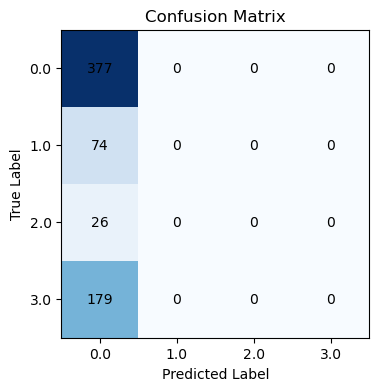

Using all test images to assess the model, the performance is: 

              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       377
         1.0       0.00      0.00      0.00        74
         2.0       0.00      0.00      0.00        26
         3.0       0.00      0.00      0.00       179

    accuracy                           0.57       656
   macro avg       0.14      0.25      0.18       656
weighted avg       0.33      0.57      0.42       656


In [28]:
# predict
predict_labels = best_model.predict(x_test)
# assess the model
performance_report(y_test, predict_labels)
accuracy_performance = metrics.classification_report(y_test, predict_labels)
print("Using all test images to assess the model, the performance is: \n")
print(accuracy_performance)

### Step2. Test the model using mono images

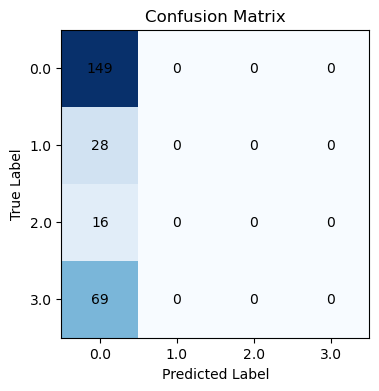

Using mono images in test set to assess the model, the performance is: 

              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73       149
         1.0       0.00      0.00      0.00        28
         2.0       0.00      0.00      0.00        16
         3.0       0.00      0.00      0.00        69

    accuracy                           0.57       262
   macro avg       0.14      0.25      0.18       262
weighted avg       0.32      0.57      0.41       262


In [34]:
# find the mono images
test_mono_indices = []
mono_indices = np.where(types == 'mono')[0]
for i in range(len(x_test)):
    for j in mono_indices:
        if np.array_equal(x_test[i], image_his[j]):
            test_mono_indices.append(i)
# predict
mono_predict_labels = best_model.predict(x_test[test_mono_indices])
# assess the model
performance_report(y_test[test_mono_indices], mono_predict_labels)
mono_accuracy_performance = metrics.classification_report(y_test[test_mono_indices], mono_predict_labels)
print("Using mono images in test set to assess the model, the performance is: \n")
print(mono_accuracy_performance)

### Step3. Test the model using poly images

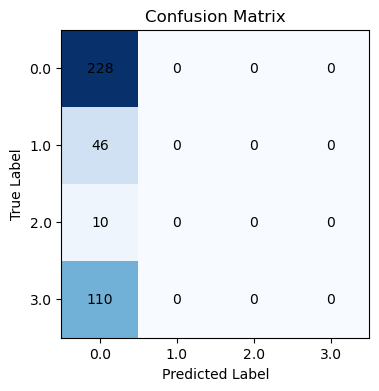

Using poly images in test set to assess the model, the performance is: 

              precision    recall  f1-score   support

         0.0       0.58      1.00      0.73       228
         1.0       0.00      0.00      0.00        46
         2.0       0.00      0.00      0.00        10
         3.0       0.00      0.00      0.00       110

    accuracy                           0.58       394
   macro avg       0.14      0.25      0.18       394
weighted avg       0.33      0.58      0.42       394


In [35]:
# find the poly images
test_poly_indices = []
poly_indices = np.where(types == 'poly')[0]
for i in range(len(x_test)):
    for j in poly_indices:
        if np.array_equal(x_test[i], image_his[j]):
            test_poly_indices.append(i)

# predict
poly_predict_labels = best_model.predict(x_test[test_poly_indices])
# assess the model
performance_report(y_test[test_poly_indices], poly_predict_labels)
poly_accuracy_performance = metrics.classification_report(y_test[test_poly_indices], poly_predict_labels)
print("Using poly images in test set to assess the model, the performance is: \n")
print(poly_accuracy_performance)